# **_Image Forgery Detection using Recompression_**


## About the dataset

## Authentic images:

1. Au_ani_00001.jpg
   Au: Authentic
   ani: animal category
2. Other categories: arc (architecture), art, cha (characters), ind (indoor), nat (nature), pla (plants), txt (texture)

## Tampering images

a. Spliced image

        Tp_D_CRN_S_N_cha00063_art00014_11818.jpg

- Tp: Tampering
- D: Different (means the tampered region was copied from the different image)
- Next 5 letters stand for the techniques they used to create the images. Unfortunately, I don't remember exactly.
- cha00063: the source image
- art00014: the target image
- 11818: tampered image ID

b. Copy-move images

        Tp_S_NRN_M_N_pla00020_pla00020_10988.jpg

- Tp: Tampering
- S: Same (means the tampered region was copied from the same image)
- And the rest is similar to case a.

If you use the groundtruth dataset for a scientific publication, please cite the following papers:

- CASIA dataset

        @inproceedings{Dong2013,
        doi = {10.1109/chinasip.2013.6625374},
        url = {https://doi.org/10.1109/chinasip.2013.6625374},
        year = {2013},
        month = jul,
        publisher = {{IEEE}},
        author = {Jing Dong and Wei Wang and Tieniu Tan},
        title = {{CASIA} Image Tampering Detection Evaluation Database},
        booktitle = {2013 {IEEE} China Summit and International Conference on Signal and Information Processing}
        }

- CASIA groundtruth dataset

       @article{pham2019hybrid,
       title={Hybrid Image-Retrieval Method for Image-Splicing Validation},
       author={Pham, Nam Thanh and Lee, Jong-Weon and Kwon, Goo-Rak and Park, Chun-Su},
       journal={Symmetry},
       volume={11},
       number={1},
       pages={83},
       year={2019},
       publisher={Multidisciplinary Digital Publishing Institute}
       }


In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
import cv2
from matplotlib import pyplot as plt
from PIL import Image, ImageChops, ImageEnhance
import os
import joblib
PATH = '../dataset/CASIA2/'


In [15]:

# PATH_TP='./dataset/CASIA2/Tp/'
data_label = ['Au', 'Tp']
label_lst = []
img_lst = []
for label in data_label:
    # print(label)
    # print(os.listdir(PATH+label))
    for img_file in os.listdir(PATH+label):
        img_lst.append(PATH+label+'/'+img_file)
        label_lst.append(label)
    # print(label_lst)


df = pd.DataFrame({'img': img_lst, 'label': label_lst})
df.head()


,img,label
0,../dataset/CASIA2/Au/Au_ani_00001.jpg,Au
1,../dataset/CASIA2/Au/Au_ani_00002.jpg,Au
2,../dataset/CASIA2/Au/Au_ani_00003.jpg,Au
3,../dataset/CASIA2/Au/Au_ani_00004.jpg,Au
4,../dataset/CASIA2/Au/Au_ani_00005.jpg,Au


In [16]:
df.label.value_counts()


Au    7491
Tp    5123
Name: label, dtype: int64

In [17]:
# def size(x):
#     return plt.imread(x).shape


# df['size'] = df['img'].apply(size)


In [18]:
# print(df['size'].head(20))
# print(df['size'].tail(20))
# # df.tail()


In [19]:
path_resaved = '../dataset/resaved/'


def difference(path):
    filename = path
    # print(path)
    resaved_name = filename.split('.')[-2]+'_resaved.jpg'
    # print(resaved_name)
    resaved_name = path_resaved+resaved_name.split('/')[-1]
    org = Image.open(filename).convert('RGB')
    org.save(resaved_name, 'JPEG', quality=90)
    resaved = Image.open(resaved_name)
    diff = ImageChops.difference(org, resaved)
    extrema = diff.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff

    diff = ImageEnhance.Brightness(diff).enhance(scale)
    # diff
    return diff


In [20]:
from keras.utils.np_utils import to_categorical
from pylab import *
X = []
y = []

for index, row in df.iterrows():
    x = array(difference(row[0]).resize((128, 128))).flatten()/255.0
    X.append(x)
    if row[1] == 'Au':
        y.append(0)
    else:
        y.append(1)

X = np.array(X)
X = X.reshape(-1, 128, 128, 3)

Y = to_categorical(y, 2)


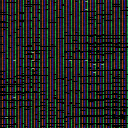

In [21]:
# x=difference(df['img'][9000]).resize((128, 128))
# # .flatten()/255.0
# x=array(x)
# print(x.shape)
# x.flatten().shape
# x
Image.fromarray(X[0], 'RGB')
# Image.fromarray(X[10].reshape((128,128,3)),'RGB')


In [22]:
import joblib

joblib.dump(X, 'X_comp_diff_org.joblib')
joblib.dump(y, 'y_comp_diff_org.joblib')


['y_comp_diff_org.joblib']

In [23]:
# import joblib
# X=joblib.load('./X_comp_diff_org.joblib')
# Y=joblib.load('./y_comp_diff_org.joblib')


In [24]:
# Y=np.array(Y)
# type(y)


In [25]:
# print(X.shape)
# y=y.reshape((-1,1))
# y.shape


### Train-Test Split


In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=5, shuffle=True)


In [27]:
print(X_train.shape, X_test.shape)
print(type(Y))


(10091, 128, 128, 3) (2523, 128, 128, 3)
<class 'numpy.ndarray'>


### Model Building


In [28]:
def build_model(activation='sigmoid'):

    model = tf.keras.Sequential()
    # input layer
    model.add(tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32,
              input_shape=[128, 128, 3], activation='relu'))

    # hidden layers
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(filters=32, padding='valid',
              kernel_size=(3,3), activation='relu'))
    # pooling
    model.add(tf.keras.layers.MaxPool2D(
        pool_size=2, padding='valid'))
    # model.add(tf.keras.layers.Dropout(.25))
    # flatten
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(.50))
    # model.add(tf.keras.layers.Dense(256, activation='relu'))
    # model.add(tf.keras.layers.Dropout(.50))

    # output layer
    model.add(tf.keras.layers.Dense(2, activation=activation))
    return model


In [29]:
# model = build_model()
# model.summary()


In [30]:
# adam = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08)
# epoch = 20
# batch_size = 33
# cal1 = tf.keras.callbacks.ModelCheckpoint(
#     save_best_only=True, filepath='sigmoid_adam.h5')
# cal2 = tf.keras.callbacks.EarlyStopping(patience=4)
# #  optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
# # model.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
# model.compile(optimizer=adam, loss='categorical_crossentropy',
#               metrics=['accuracy'])
# # history = model.fit(X_train, y_train, validation_data=(
# #     X_test, y_test), batch_size=batch_size, epochs=epoch, callbacks=[cal1, cal2])
# history = model.fit(X_train, y_train, validation_data=(
#     X_test, y_test), batch_size=batch_size, epochs=epoch)
# history = history.history


In [31]:
# model.save("model_sigmoid.h5")


In [32]:
from sklearn.metrics import confusion_matrix

# y_pred = model.predict(X_test)

# # confusion_matrix(y_pred, y_test)
# y_pred


In [33]:
# y_pred = np.where(y_pred >= 0.5, 1, 0)


In [34]:
# y_pred = y_pred.astype('float32')
# y_pred = np.argmax(y_pred, axis=1)


In [35]:
# confusion_matrix(y_pred=y_pred, y_true=y_test.argmax(axis=1))


In [36]:
# plt.plot(range(1, 7), history['loss'])
# plt.plot(range(1, 7), history['val_loss'])
# plt.legend(['Training loss', 'Validation loss'])
# plt.title('Learning Curve')
# plt.xlabel('Epochs')
# plt.ylabel('loss')


In [37]:
softmax_adam = build_model('softmax')
softmax_adam.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      9248      
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 119072)            0         
                                                                 
 dense_2 (Dense)             (None, 256)               30482688  
                                                      

In [41]:
adam = tf.keras.optimizers.Adam(learning_rate=0.003, epsilon=1e-08)
epoch = 20
batch_size = 33
cal1 = tf.keras.callbacks.ModelCheckpoint(save_best_only=True, filepath='softmax_adam.h5')
cal2 = tf.keras.callbacks.EarlyStopping(patience=5)
# optimizer = RMSprop(lr=lr, rho=0.9, epsilon=1e-08, decay=0.0)
# softmax_adam.compile(optimizer='adam', loss= 'binary_crossentropy', metrics=['accuracy'])
softmax_adam.compile(optimizer=adam, loss='categorical_crossentropy',
              metrics=['accuracy'])
history = softmax_adam.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epoch, callbacks=[cal2])
history = history.history 

Epoch 1/20
306/306 [==============================] - 263s 854ms/step - loss: 0.4418 - accuracy: 0.7991 - val_loss: 0.4260 - val_accuracy: 0.8094
Epoch 2/20
306/306 [==============================] - 259s 847ms/step - loss: 0.4161 - accuracy: 0.8341 - val_loss: 0.3778 - val_accuracy: 0.8565
Epoch 3/20
306/306 [==============================] - 255s 833ms/step - loss: 0.3569 - accuracy: 0.8618 - val_loss: 0.3547 - val_accuracy: 0.8577
Epoch 4/20
306/306 [==============================] - 256s 835ms/step - loss: 0.3259 - accuracy: 0.8732 - val_loss: 0.3737 - val_accuracy: 0.8656
Epoch 5/20
306/306 [==============================] - 249s 815ms/step - loss: 0.2943 - accuracy: 0.8858 - val_loss: 0.3976 - val_accuracy: 0.8541
Epoch 6/20
306/306 [==============================] - 244s 798ms/step - loss: 0.2747 - accuracy: 0.8943 - val_loss: 0.4295 - val_accuracy: 0.8652
Epoch 7/20
306/306 [==============================] - 244s 797ms/step - loss: 0.2452 - accuracy: 0.9026 - val_loss: 0.4268 -

In [42]:
softmax_adam.save('softmax_adam85.h5')

Text(0, 0.5, 'loss')

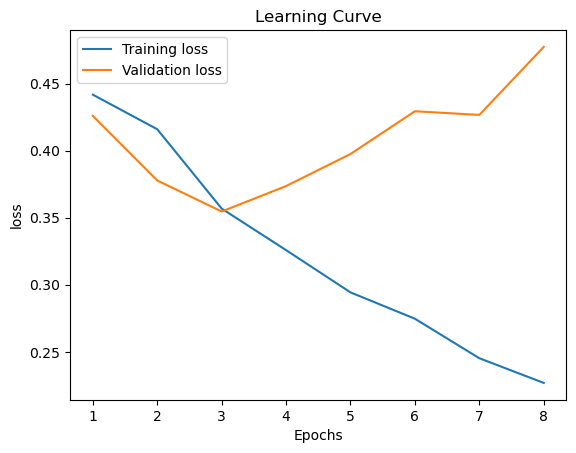

In [44]:
plt.plot(range(1, 9), history['loss'])
plt.plot(range(1, 9), history['val_loss'])
plt.legend(['Training loss', 'Validation loss'])
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('loss')

In [ ]:
from sklearn.metrics import recall_score, accuracy_score, precision_score

def print_score(acc, precision, recall):
    print(f"Recall score: {recall}")
    print(f"Precision score: {precision}")
    print(f"Accuracy score: {acc}")

In [ ]:

y_pred = softmax_adam.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_t=np.argmax(y_test, axis=1)
# print_score()
print_score(recall=recall_score(y_pred=y_pred, y_true=y_t), precision=precision_score(
    y_pred=y_pred, y_true=y_t), acc=accuracy_score(y_pred=y_pred, y_true=y_t))
confusion_matrix(y_pred=y_pred, y_true=y_t)


79/79 [==============================] - 11s 142ms/step
Recall score: 0.9244019138755981
Precision score: 0.8356401384083045
Accuracy score: 0.893380895759017


array([[1288,  190],
       [  79,  966]], dtype=int64)

In [ ]:
from tensorflow.keras.models import load_model
model_sigmoid = load_model('./sigmoid_adam.h5')

y_pred = model_sigmoid.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_t=np.argmax(y_test, axis=1)
# print_score()
print_score(recall=recall_score(y_pred=y_pred, y_true=y_t), precision=precision_score(
    y_pred=y_pred, y_true=y_t), acc=accuracy_score(y_pred=y_pred, y_true=y_t))
confusion_matrix(y_pred=y_pred, y_true=y_t)

79/79 [==============================] - 11s 142ms/step
Recall score: 0.9330143540669856
Precision score: 0.7933279088689992
Accuracy score: 0.8715814506539834


array([[1224,  254],
       [  70,  975]], dtype=int64)